# Dataset Bespoke Subsampling Demo

This notebook demonstrates how to subsample a dataset to have a specific episode return histogram.

In [1]:
from og_marl.vault_utils.download_vault import *
from og_marl.vault_utils.combine_vaults import *
from og_marl.vault_utils.analyse_vault import *
from og_marl.vault_utils.subsample_bespoke import bin_processed_data,episode_idxes_sampled_from_pdf
from og_marl.vault_utils.subsample_similar import sort_concat, stitch_vault_from_sampled_episodes_, get_episode_returns_and_term_idxes

See dataset_analysis_demo for more information on downloading and accessing OG-MARL vaults.

In [2]:
# download / make sure dataset exists
source = 'omar'
env = 'mpe'
task = 'simple_spread'

rel_vault_location = download_and_unzip_vault(source,env,task)
vault_uids = get_available_uids(rel_vault_location)

vault_rel_dir = f"vaults/{source}/{env}" # combine base vault directory with the dataset source and environment folders
vault_name = f"{task}.vlt" # a vault name contains only the file name which has the .vlt extension

Vault './vaults/omar/mpe/simple_spread' already exists.


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Loading vault found at /home/louise/workspace/og-marl/examples/vaults/omar/mpe/simple_spread.vlt/Random
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/omar/mpe/simple_spread.vlt/Medium-Replay
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/omar/mpe/simple_spread.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/omar/mpe/simple_spread.vlt/Expert
Uid               Mean    Stddev    Min return    Max return    Transitions    Trajectories    Joint SACo
-------------  -------  --------  ------------  ------------  -------------  --------------  ------------
Random         159.572   60.4562      -5.43332       510.046        1000000           40000             1
Medium-Replay  203.739   80.493       35.6928        582.086          97500            3900             1
Medium         273.395   92.0589      27.3476        649.505        1000000           40000             1
Expert         530.949   71.4089      54.9621  

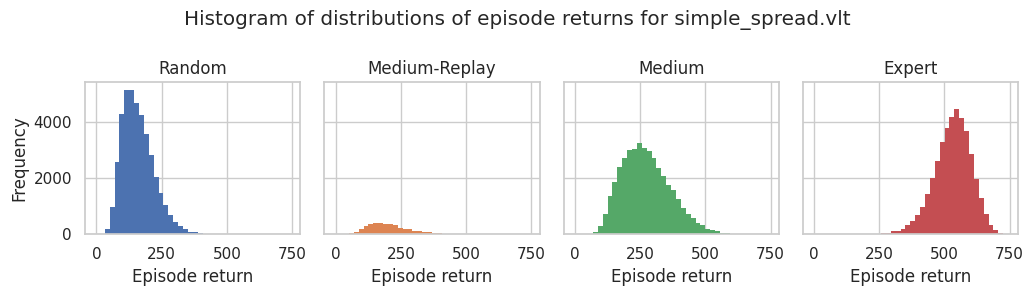

In [3]:
head = descriptive_summary(vault_name=vault_name,vault_uids=vault_uids,rel_dir=vault_rel_dir)

For further information about a Vault's api, please see the dataset api demo.

['Random', 'Medium-Replay', 'Medium', 'Expert']
Vault 'vaults/omar/mpe/simple_spread_combined' already exists. To combine from scratch, please remove the current combined vault from its directory.
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/omar/mpe/simple_spread_combined.vlt/Random_Medium-Replay_Medium_Expert
Uid                                    Mean    Stddev    Min return    Max return    Transitions    Trajectories    Joint SACo
----------------------------------  -------  --------  ------------  ------------  -------------  --------------  ------------
Random_Medium-Replay_Medium_Expert  317.605   171.937      -5.43332       743.886        3097500          123900             1


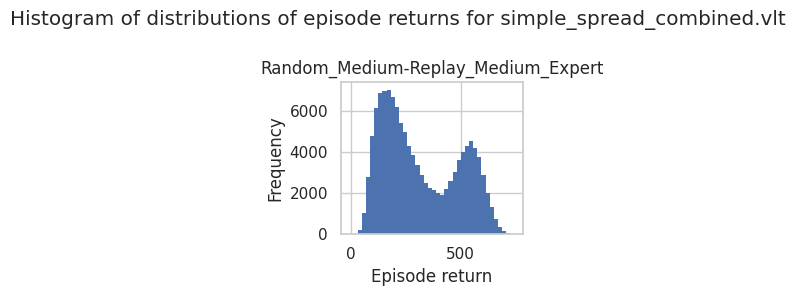

In [4]:
comb_vault_name = combine_vaults(vault_rel_dir,vault_name,vault_uids=vault_uids)

comb_vault_name = f"{vault_name.removesuffix('.vlt')}_combined.vlt"

returns = descriptive_summary(vault_name=comb_vault_name, rel_dir=vault_rel_dir,save_hist=True)

## Subsample a vault "by hand"

Given a histogram of episode returns, we allow subsampling a vault according to the histogram in a flexible way. That is, we allow individual specification of the size of each bucket.

### Dataset description to guide subsampling

In [5]:
# it can be useful to have experience handy at this level
print(comb_vault_name)
print(vault_rel_dir)
uids = get_available_uids(f"{vault_rel_dir}/{comb_vault_name}")
vlt = Vault(vault_name=comb_vault_name,rel_dir=vault_rel_dir,vault_uid=uids[0])
all_data = vlt.read()
offline_data = all_data.experience
del all_data

simple_spread_combined.vlt
vaults/omar/mpe
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/omar/mpe/simple_spread_combined.vlt/Random_Medium-Replay_Medium_Expert


In [6]:
returns, episode_end_idxes = get_episode_returns_and_term_idxes(offline_data)
sorted_return_start_end = sort_concat(returns,episode_end_idxes)
bar_labels, bar_heights, padded_heights, bin_edges, bin_numbers = bin_processed_data(sorted_return_start_end, n_bins=250)

123900
123900


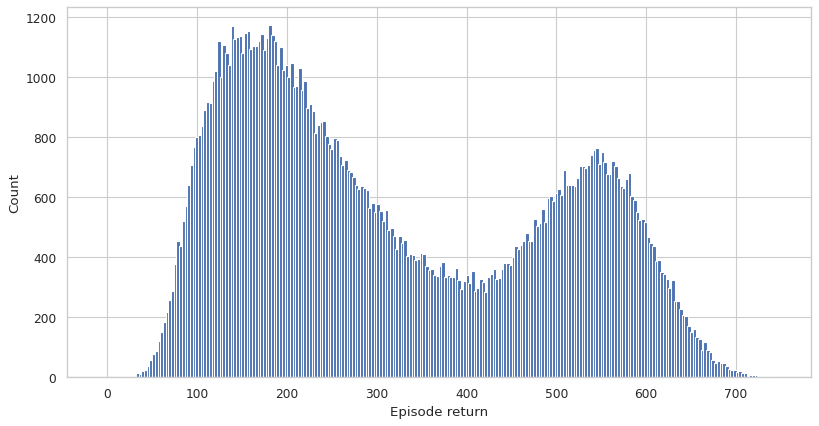

[   1    1    2    1    3    5   12   11   21   23   36   56   76   86
  121  151  185  216  258  286  377  454  437  521  570  639  706  767
  799  808  836  891  916  913  988 1019 1121  999 1107 1081 1042 1171
 1127 1134 1137 1079 1146 1155 1094 1104 1103 1121 1145 1092 1129 1174
 1140 1121 1039 1099 1023 1041 1002 1047  967  971 1029  957  987  897
  911  888  814  841  851  854  804  776  761  797  789  737  707  725
  692  685  667  641  626  638  629  624  565  580  549  578  554  519
  558  489  497  470  427  471  446  456  402  409  407  389  393  414
  409  369  356  360  339  338  370  382  332  339  335  334  364  324
  293  321  341  313  352  288  296  326  318  284  332  342  361  328
  331  359  381  381  374  401  436  428  439  454  480  453  453  526
  505  513  560  517  597  604  586  613  627  608  692  639  641  642
  636  663  703  704  697  708  740  758  763  712  750  717  676  678
  719  703  663  638  630  660  682  605  590  551  522  527  517  467
  448 

In [7]:
# print the histogram to show the distribution
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6), dpi=80)
plt.bar(bin_edges,padded_heights,width=4)
plt.ylabel("Count")
plt.xlabel("Episode return")
plt.show()

print(bar_heights)

### Plot a pdf under the distribution to specify how many episodes to sample

Although we allow manual specification of how many episodes to sample from each bucket, it can be easier to sample according to a distribution defined by a function. We use the Gaussian distribution as an example.

Important to note, we plot the distribution with bin numbers as the unit since it is dataset-agnostic.

In [8]:
def uniform_pdf(x_vals,l_lim,r_lim,vol):
    """Generate an array indexed by bin number of a uniform pdf in histogram format.
    l_lim: left limit of uniform pdf
    r_lim: right limit of uniform pdf
    vol: number of samples (approximately) of the pdf
    """
    
    height = vol/(r_lim-l_lim)
    y_vals = [height if (x>=l_lim and x<=r_lim) else 0 for x in x_vals]

    return np.array(y_vals).astype(int)

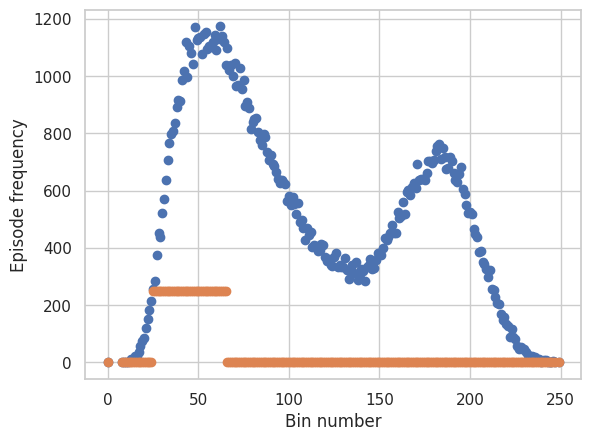

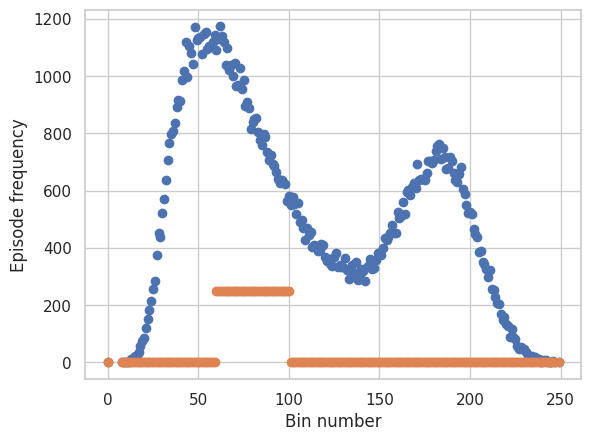

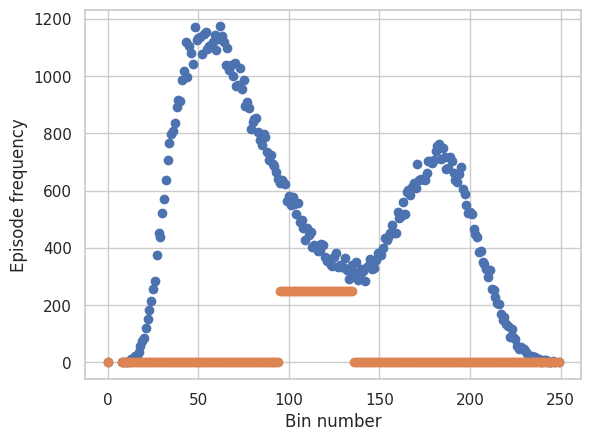

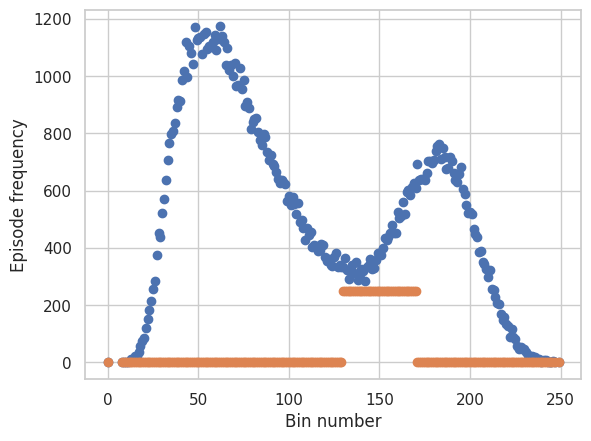

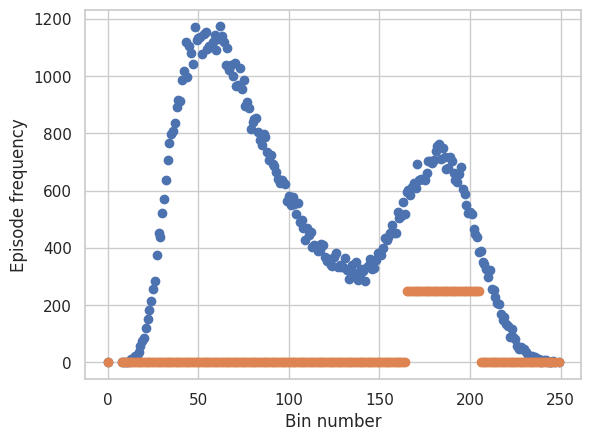

In [10]:
# visualise original distribution
plt.scatter(bar_labels,bar_heights)
# uniform_pdf_vals_1 = uniform_pdf(bar_labels,20,220,10000)
uniform_pdf_vals_1 = uniform_pdf(bar_labels,25,65,10000)
plt.scatter(bar_labels,uniform_pdf_vals_1)
plt.ylabel("Episode frequency")
plt.xlabel("Bin number")
plt.savefig("pdf_under_dist.pdf",bbox_inches='tight',format='pdf')
plt.show()

# visualise original distribution
plt.scatter(bar_labels,bar_heights)
# uniform_pdf_vals_2 = uniform_pdf(bar_labels,100,140,10000)
uniform_pdf_vals_2 = uniform_pdf(bar_labels,60,100,10000)
plt.scatter(bar_labels,uniform_pdf_vals_2)
plt.ylabel("Episode frequency")
plt.xlabel("Bin number")
plt.savefig("pdf_under_dist.pdf",bbox_inches='tight',format='pdf')
plt.show()

# visualise original distribution
plt.scatter(bar_labels,bar_heights)
# uniform_pdf_vals_3 = uniform_pdf(bar_labels,40,200,10000)
uniform_pdf_vals_3 = uniform_pdf(bar_labels,95,135,10000)
plt.scatter(bar_labels,uniform_pdf_vals_3)
plt.ylabel("Episode frequency")
plt.xlabel("Bin number")
plt.savefig("pdf_under_dist.pdf",bbox_inches='tight',format='pdf')
plt.show()

# visualise original distribution
plt.scatter(bar_labels,bar_heights)
# uniform_pdf_vals_4 = uniform_pdf(bar_labels,60,180,10000)
uniform_pdf_vals_4 = uniform_pdf(bar_labels,130,170,10000)
plt.scatter(bar_labels,uniform_pdf_vals_4)
plt.ylabel("Episode frequency")
plt.xlabel("Bin number")
plt.savefig("pdf_under_dist.pdf",bbox_inches='tight',format='pdf')
plt.show()

# visualise original distribution
plt.scatter(bar_labels,bar_heights)
# uniform_pdf_vals_5 = uniform_pdf(bar_labels,80,160,10000)
uniform_pdf_vals_5 = uniform_pdf(bar_labels,165,205,10000)
plt.scatter(bar_labels,uniform_pdf_vals_5)
plt.ylabel("Episode frequency")
plt.xlabel("Bin number")
plt.savefig("pdf_under_dist.pdf",bbox_inches='tight',format='pdf')
plt.show()

Generally, you want the sampling pdf to lie below the actual pdf. We allow for oversampling (then episodes are repeated), but it will in essence just impact the bias towards the resampled episodes.

10250
10250


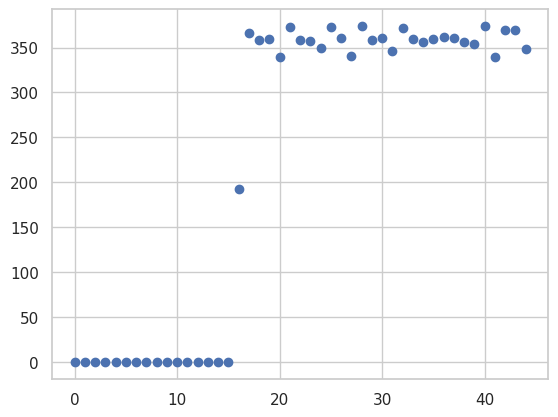

128.5073
35.606247
10250
10250
10250


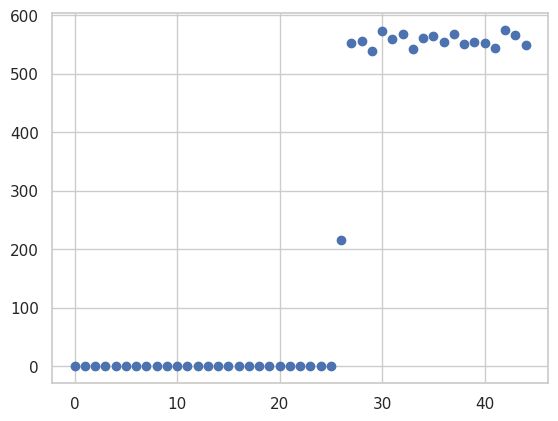

233.78697
35.607944
10250
10250
10250


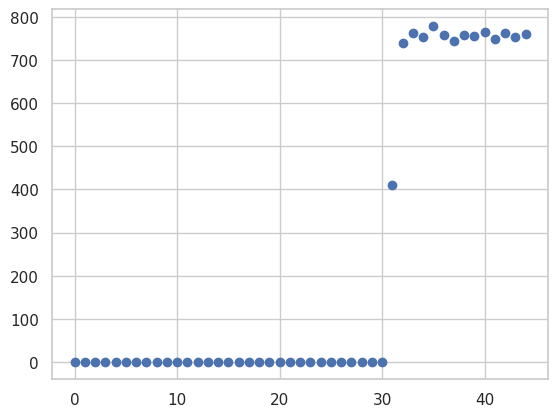

339.14502
35.63282
10250
10250
10250


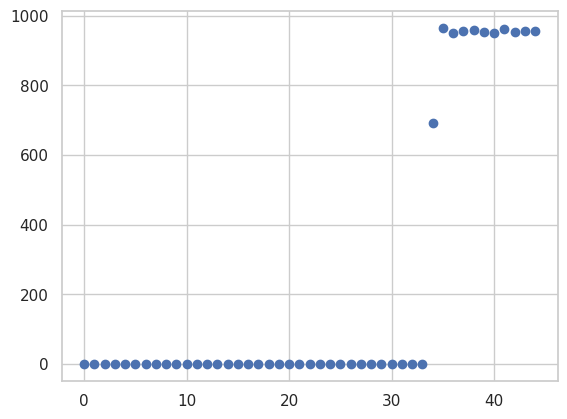

444.4613
35.61458
10250
10250
10250


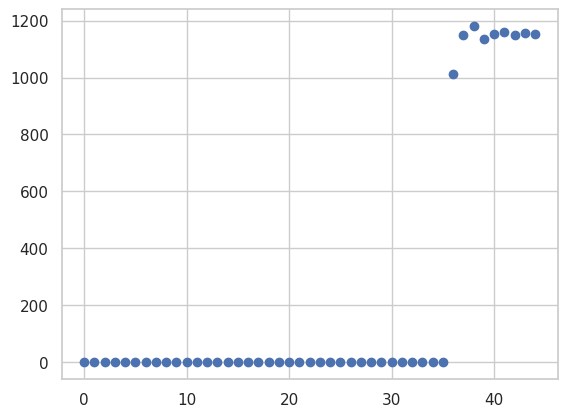

549.7831
35.60217
10250


In [11]:
target_pdfs = [uniform_pdf_vals_1,uniform_pdf_vals_2, uniform_pdf_vals_3,uniform_pdf_vals_4, uniform_pdf_vals_5]

target_infoblocks = []
for pdf in target_pdfs:
    # from each bin, select indexes to slice the return_start_end info block
    target_sample_idxes = episode_idxes_sampled_from_pdf(pdf,bar_heights)

    # do the selection according to the indices you just sampled
    target_return_start_end = sorted_return_start_end[np.array(target_sample_idxes).astype(int),:]

    # visualise the subsampled distribution
    bar_labels_t, bar_heights_t, padded_heights_t, bin_edges_t, bin_numbers_t = bin_processed_data(target_return_start_end, n_bins=45)
    bins_t = range(len(padded_heights_t))
    plt.scatter(bins_t,padded_heights_t)
    plt.show()

    # further print the mean and stddev of episode returns of the subsampled distribution
    print(np.mean(target_return_start_end[:,0]))
    print(np.std(target_return_start_end[:,0]))
    print(len(target_return_start_end))

    target_infoblocks.append(target_return_start_end)

## Now restitch the vault using the experience from before. 
A sanity check afterwards is recommended.

New vault created at /home/louise/workspace/og-marl/examples/vaults/omar/mpe/mean_matters_simple_spread/a
Since the provided buffer state has a temporal dimension of 1000000, you must write to the vault at least every 999999 timesteps to avoid data loss.
256250
New vault created at /home/louise/workspace/og-marl/examples/vaults/omar/mpe/mean_matters_simple_spread/b
Since the provided buffer state has a temporal dimension of 1000000, you must write to the vault at least every 999999 timesteps to avoid data loss.
256250
New vault created at /home/louise/workspace/og-marl/examples/vaults/omar/mpe/mean_matters_simple_spread/c
Since the provided buffer state has a temporal dimension of 1000000, you must write to the vault at least every 999999 timesteps to avoid data loss.
256250
New vault created at /home/louise/workspace/og-marl/examples/vaults/omar/mpe/mean_matters_simple_spread/d
Since the provided buffer state has a temporal dimension of 1000000, you must write to the vault at least ev

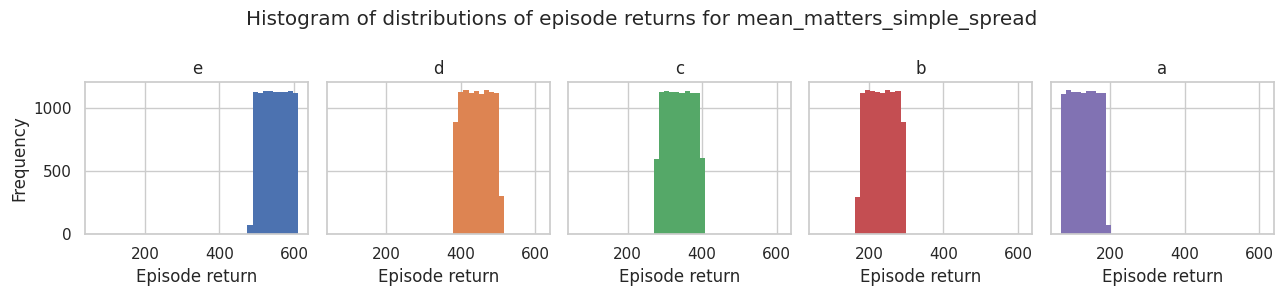

In [13]:
dest_vault_name = 'mean_matters_simple_spread'

new_uids = ['a','b','c','d','e']

for new_uid,infoblock in zip(new_uids,target_infoblocks):
    stitch_vault_from_sampled_episodes_(offline_data,infoblock,dest_vault_name,rel_dir=vault_rel_dir,vault_uid=f'{new_uid}',n=1000000)

returns = descriptive_summary(dest_vault_name,rel_dir=vault_rel_dir,save_hist=True)